**Objective**: The primary objective of this project is to automate the mapping of discharge summaries and associated medical data to standardized medical code ( ICS or CCS codes)

#### **Adding imports**

In [61]:
# import necessary libraries
import pandas as pd
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns


In [62]:
# declare the global variables
important_columns = ['CCSR Diagnosis Description', 'APR DRG Description']    
columns_to_drop = ['Payment Typology 1','Payment Typology 2', 'Payment Typology 3', 'Birth Weight', 
                   'CCSR Procedure Code', 'CCSR Procedure Description']

#### **Load the dataset**

In [63]:
# read the discharge summaries dataset
# Ensure the path is correct relative to your current working directory
summaries_df = pd.read_csv('./data/discharge_summaries_dataset.csv')
# Display the first 5 rows of the dataset   
display(summaries_df.tail(5))
# Display the shape of the dataset
print(f"Shape of the dataset: {summaries_df.shape}")
# Display the columns of the dataset
print(f"Columns in the dataset: {summaries_df.columns}")


,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Payment Typology 1,Payment Typology 2,Payment Typology 3,Birth Weight,Emergency Department Indicator,Total Charges,Total Costs
2135255,Long Island,Suffolk,5153000.0,913.0,Huntington Hospital,70 or Older,117,M,White,Not Span/Hispanic,...,Major,Major,Surgical,Medicare,Medicare,Blue Cross/Blue Shield,NaN,Y,67029.14,17052.81
2135256,Long Island,Suffolk,5153000.0,913.0,Huntington Hospital,70 or Older,117,M,White,Not Span/Hispanic,...,Major,Major,Medical,Medicare,Medicare,Blue Cross/Blue Shield,NaN,Y,34050.80,21813.32
2135257,Long Island,Suffolk,5153000.0,913.0,Huntington Hospital,70 or Older,117,F,White,Not Span/Hispanic,...,Major,Major,Medical,Medicare,Medicare,Private Health Insurance,NaN,Y,32157.37,7719.76
2135258,Long Island,Suffolk,5153000.0,913.0,Huntington Hospital,70 or Older,117,F,White,Not Span/Hispanic,...,Moderate,Moderate,Medical,"Managed Care, Unspecified",Medicare,NaN,NaN,Y,56847.68,15515.27
2135259,New York City,Kings,7001020.0,1305.0,Maimonides Medical Center,30 to 49,112,F,Black/African American,Not Span/Hispanic,...,Minor,Minor,Medical,Miscellaneous/Other,Private Health Insurance,Self-Pay,NaN,Y,27830.00,6849.32


Shape of the dataset: (2135260, 33)
Columns in the dataset: Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code',
       'CCSR Diagnosis Description', 'CCSR Procedure Code',
       'CCSR Procedure Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Payment Typology 1',
       'Payment Typology 2', 'Payment Typology 3', 'Birth Weight',
       'Emergency Department Indicator', 'Total Charges', 'Total Costs'],
      dtype='object')


#### **Clean the dataset**

In the cleaning part, we are not cleaning the entire dataset . We will be just focussing on the column *CCSR Diagnosis Description* and dropping any rows which have null values.

In [64]:
# Check for missing values in the dataset
print("Missing values in each column:")
display(summaries_df.isnull().sum())

Missing values in each column:


Hospital Service Area                     5214
Hospital County                           5214
Operating Certificate Number              6663
Permanent Facility Id                     5214
Facility Name                                0
Age Group                                    0
Zip Code - 3 digits                      40246
Gender                                       0
Race                                         0
Ethnicity                                    0
Length of Stay                               0
Type of Admission                            0
Patient Disposition                          0
Discharge Year                               0
CCSR Diagnosis Code                          0
CCSR Diagnosis Description                   0
CCSR Procedure Code                     583187
CCSR Procedure Description              583187
APR DRG Code                                 0
APR DRG Description                          0
APR MDC Code                                 0
APR MDC Descr

**Drop Columns**

In [65]:
# Dropping columns which are not important for our analysis
summaries_df_cleaned = summaries_df.drop(columns=columns_to_drop)
# Display the shape of the cleaned dataset
print(f"Shape of the cleaned dataset: {summaries_df_cleaned.shape}")
# Display the columns of the cleaned dataset
print(f"Columns in the cleaned dataset: {summaries_df_cleaned.columns}")
# Display the shape of the cleaned dataset
display(summaries_df_cleaned.isnull().sum())

Shape of the cleaned dataset: (2135260, 27)
Columns in the cleaned dataset: Index(['Hospital Service Area', 'Hospital County',
       'Operating Certificate Number', 'Permanent Facility Id',
       'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race',
       'Ethnicity', 'Length of Stay', 'Type of Admission',
       'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code',
       'CCSR Diagnosis Description', 'APR DRG Code', 'APR DRG Description',
       'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code',
       'APR Severity of Illness Description', 'APR Risk of Mortality',
       'APR Medical Surgical Description', 'Emergency Department Indicator',
       'Total Charges', 'Total Costs'],
      dtype='object')


Hospital Service Area                   5214
Hospital County                         5214
Operating Certificate Number            6663
Permanent Facility Id                   5214
Facility Name                              0
Age Group                                  0
Zip Code - 3 digits                    40246
Gender                                     0
Race                                       0
Ethnicity                                  0
Length of Stay                             0
Type of Admission                          0
Patient Disposition                        0
Discharge Year                             0
CCSR Diagnosis Code                        0
CCSR Diagnosis Description                 0
APR DRG Code                               0
APR DRG Description                        0
APR MDC Code                               0
APR MDC Description                        0
APR Severity of Illness Code               0
APR Severity of Illness Description      589
APR Risk o

**Fill the ZipCode with 000 instead of null values and Birth Weight with 0 with null values**

In [66]:
summaries_df_cleaned['Zip Code - 3 digits'].fillna('000', inplace=True)
summaries_df_cleaned.isnull().sum()
display(summaries_df_cleaned.head(5))

,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR DRG Description,APR MDC Code,APR MDC Description,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Emergency Department Indicator,Total Charges,Total Costs
0,New York City,Bronx,7000006.0,1169.0,Montefiore Medical Center - Henry & Lucy Moses...,70 or Older,104,M,Other Race,Spanish/Hispanic,...,MAJOR RESPIRATORY INFECTIONS AND INFLAMMATIONS,4,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,3,Major,Extreme,Medical,Y,320922.43,60241.34
1,New York City,Bronx,7000006.0,1169.0,Montefiore Medical Center - Henry & Lucy Moses...,50 to 69,104,F,White,Not Span/Hispanic,...,"MULTIPLE SCLEROSIS, OTHER DEMYELINATING DISEAS...",1,DISEASES AND DISORDERS OF THE NERVOUS SYSTEM,2,Moderate,Minor,Medical,Y,61665.22,9180.69
2,New York City,Bronx,7000006.0,1168.0,Montefiore Medical Center-Wakefield Hospital,18 to 29,104,F,Other Race,Spanish/Hispanic,...,CESAREAN SECTION WITHOUT STERILIZATION,14,"PREGNANCY, CHILDBIRTH AND THE PUERPERIUM",1,Minor,Minor,Surgical,N,42705.34,11366.50
3,New York City,Bronx,7000006.0,3058.0,Montefiore Med Center - Jack D Weiler Hosp of ...,70 or Older,104,M,Other Race,Spanish/Hispanic,...,KIDNEY AND URINARY TRACT INFECTIONS,11,DISEASES AND DISORDERS OF THE KIDNEY AND URINA...,3,Major,Major,Medical,Y,72700.17,12111.75
4,New York City,Bronx,7000006.0,1169.0,Montefiore Medical Center - Henry & Lucy Moses...,50 to 69,104,F,Black/African American,Not Span/Hispanic,...,OTHER DISORDERS OF NERVOUS SYSTEM,1,DISEASES AND DISORDERS OF THE NERVOUS SYSTEM,2,Moderate,Minor,Medical,Y,55562.51,8339.72


**Convert the cleaned dataset to csv**

In [67]:
summaries_df_cleaned.to_csv("./data/cleaned_medical_dataset.csv", index=False)
display(summaries_df_cleaned.tail(5))



,Hospital Service Area,Hospital County,Operating Certificate Number,Permanent Facility Id,Facility Name,Age Group,Zip Code - 3 digits,Gender,Race,Ethnicity,...,APR DRG Description,APR MDC Code,APR MDC Description,APR Severity of Illness Code,APR Severity of Illness Description,APR Risk of Mortality,APR Medical Surgical Description,Emergency Department Indicator,Total Charges,Total Costs
2135255,Long Island,Suffolk,5153000.0,913.0,Huntington Hospital,70 or Older,117,M,White,Not Span/Hispanic,...,MODERATELY EXTENSIVE O.R. PROCEDURE UNRELATED ...,11,DISEASES AND DISORDERS OF THE KIDNEY AND URINA...,3,Major,Major,Surgical,Y,67029.14,17052.81
2135256,Long Island,Suffolk,5153000.0,913.0,Huntington Hospital,70 or Older,117,M,White,Not Span/Hispanic,...,"MALFUNCTION, REACTION, COMPLICATION OF CARDIAC...",5,DISEASES AND DISORDERS OF THE CIRCULATORY SYSTEM,3,Major,Major,Medical,Y,34050.80,21813.32
2135257,Long Island,Suffolk,5153000.0,913.0,Huntington Hospital,70 or Older,117,F,White,Not Span/Hispanic,...,"MALFUNCTION, REACTION, COMPLICATION OF GENITOU...",11,DISEASES AND DISORDERS OF THE KIDNEY AND URINA...,3,Major,Major,Medical,Y,32157.37,7719.76
2135258,Long Island,Suffolk,5153000.0,913.0,Huntington Hospital,70 or Older,117,F,White,Not Span/Hispanic,...,RESPIRATORY FAILURE,4,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,2,Moderate,Moderate,Medical,Y,56847.68,15515.27
2135259,New York City,Kings,7001020.0,1305.0,Maimonides Medical Center,30 to 49,112,F,Black/African American,Not Span/Hispanic,...,ASTHMA,4,DISEASES AND DISORDERS OF THE RESPIRATORY SYSTEM,1,Minor,Minor,Medical,Y,27830.00,6849.32


**Prepare the data**

In [68]:
unique_diagnoses = summaries_df_cleaned['CCSR Diagnosis Description'].astype(str).unique().tolist()
# Display the number of unique diagnoses
print(f"Number of unique diagnoses: {len(unique_diagnoses)}")
display(unique_diagnoses)

Number of unique diagnoses: 478


['COVID-19',
 'Multiple sclerosis',
 'Previous C-section',
 'Urinary tract infections',
 'Paralysis (other than cerebral palsy)',
 'Complication of other surgical or medical care, injury, initial encounter',
 'Traumatic brain injury (TBI); concussion, initial encounter',
 'Liveborn',
 'Noninfectious gastroenteritis',
 'Asthma',
 'Sickle cell trait/anemia',
 'Other specified diseases of veins and lymphatics',
 'Stress fracture, initial encounter',
 'Encounter for antineoplastic therapies',
 'Benign neoplasms',
 'Nerve and nerve root disorders',
 'Complication of transplanted organs or tissue, initial encounter',
 'Fluid and electrolyte disorders',
 'Intestinal obstruction and ileus',
 'Epilepsy; convulsions',
 'Male reproductive system cancers - prostate',
 'Schizophrenia spectrum and other psychotic disorders',
 'Coronary atherosclerosis and other heart disease',
 'Alcohol-related disorders',
 'Hypertension and hypertensive-related conditions complicating pregnancy; childbirth; and the

**Using TF_IDF + Cosine Similarity**

In [69]:

# vectorizer = TfidfVectorizer()

# # Vectorize all unique diagnosis descriptions (reference list)
# diagnosis_matrix = vectorizer.fit_transform(unique_diagnoses)

# # Vectorize actual diagnosis descriptions in the dataset
# query_matrix = vectorizer.transform(summaries_df_cleaned['CCSR Diagnosis Description'].astype(str))

# # Compute Similarity in Bulk
# similarity_matrix = cosine_similarity(query_matrix, diagnosis_matrix)

# # Extract Best Matches and Scores
# best_match_indices = similarity_matrix.argmax(axis=1)
# best_scores = similarity_matrix.max(axis=1)
# best_matches = [unique_diagnoses[i] for i in best_match_indices]

# #  Add Results to DataFrame
# summaries_df_cleaned['Matched Description'] = best_matches
# summaries_df_cleaned['Similarity Score'] = best_scores

# # Save Result
# summaries_df_cleaned.to_csv("./data/final_matched_results.csv", index=False)
# print("Fast matching completed and saved as 'final_matched_results.csv'")

vectorizer = TfidfVectorizer()

# Vectorize unique diagnosis descriptions
diagnosis_matrix = vectorizer.fit_transform(unique_diagnoses)

# Vectorize all rows' descriptions
query_matrix = vectorizer.transform(summaries_df_cleaned['CCSR Diagnosis Description'].astype(str))

# Compute similarity
similarity_matrix = cosine_similarity(query_matrix, diagnosis_matrix)

# Extract matches
best_match_indices = similarity_matrix.argmax(axis=1)
best_scores = similarity_matrix.max(axis=1)
best_matches = [unique_diagnoses[i] for i in best_match_indices]

# Match descriptions to codes
description_to_code = dict(zip(summaries_df_cleaned['CCSR Diagnosis Description'], 
                               summaries_df_cleaned['CCSR Diagnosis Code']))
matched_codes = [description_to_code.get(desc, "") for desc in best_matches]

# Add to DataFrame
summaries_df_cleaned['Matched Description'] = best_matches
summaries_df_cleaned['Matched Code'] = matched_codes
summaries_df_cleaned['Similarity Score'] = best_scores

# Save
summaries_df_cleaned.to_csv("./data/final_matched_results.csv", index=False)
print("Matching complete. Saved to final_matched_results.csv")




Matching complete. Saved to final_matched_results.csv


**Evaluation matrix**

In [70]:
y_true = summaries_df_cleaned['CCSR Diagnosis Code'].astype(str)
y_pred = summaries_df_cleaned['Matched Code'].astype(str)


accuracy = accuracy_score(y_true, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

print("Evaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")



Evaluation Metrics:
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000


**Add visualizations**

We create a bar chart for top most predicted medical codes

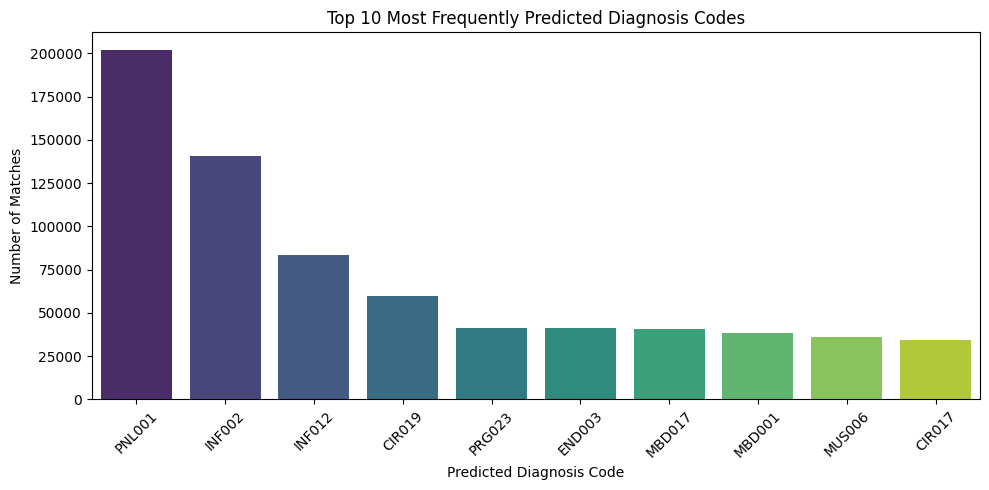

In [71]:
top_codes = summaries_df_cleaned['Matched Code'].value_counts().head(10).reset_index()
top_codes.columns = ['CCSR Diagnosis Code', 'Count']

plt.figure(figsize=(10, 5))
sns.barplot(data=top_codes, x='CCSR Diagnosis Code', y='Count', palette='viridis')
plt.title("Top 10 Most Frequently Predicted Diagnosis Codes")
plt.ylabel("Number of Matches")
plt.xlabel("Predicted Diagnosis Code")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()